In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
file = open("/content/drive/My Drive/Colab Notebooks/train_data_first_50.pkl","rb")


In [0]:
data_train = pickle.load(file)


In [0]:
data_train = data_train.values()

In [0]:
data_train = list(data_train)

In [0]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils import data
import torch.nn.functional as F
from tqdm.notebook  import tqdm

In [0]:
max_leng = 80

encoder_input_dim = 13
decoder_hidden_dim = 50
encoder_hidden_dim = 50
decoder_output_dim = 13
BATCH_SIZE = 512


In [0]:
def padding(mfcc_feature, max_leng = max_leng):
  length = mfcc_feature.shape[0]
  if(length > max_leng):
    ret = mfcc_feature[:max_leng,:]
  elif(length < max_leng):
    diff = max_leng- length
    zeros = np.zeros((diff,13))
    ret = np.concatenate((mfcc_feature,zeros),axis = 0)
  else:
    ret = mfcc_feature
  return ret


In [0]:
windowed_x = []
windowed_y1 = []
windowed_y2 = []
for sect in tqdm(data_train):
  for word_i in range(1,len(sect)-1):
    
    x_temp = padding(sect[word_i])
    y1_temp = padding(sect[word_i - 1])
    y2_temp = padding(sect[word_i + 1])

    if x_temp.shape == (max_leng,13) and y1_temp.shape == (max_leng,13) and y2_temp.shape == (max_leng,13):
      windowed_x.append(x_temp)
      windowed_y1.append(y1_temp)
      windowed_y2.append(y2_temp)
    else:
      print("shape error!",x_temp.shape,y1_temp.shape,y2_temp.shape)


In [0]:
print(len(windowed_x))

218070


In [0]:
windowed_x = windowed_x
windowed_y1 = windowed_y1
windowed_y2 = windowed_y2

In [0]:
del data_train

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim , enc_hid_dim):
        super().__init__()
        
        self.rnn = nn.GRU(input_dim, enc_hid_dim, bidirectional = True,batch_first = True)
        
                
    def forward(self, input):
        
        #input = [src len, batch size]
      
        
        outputs, hidden = self.rnn(input)
                
        #outputs = [batch size,src len, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        
        return outputs, hidden

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
      
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()

        self.attention = attention
         
        self.rnn = nn.GRU((enc_hid_dim * 2), dec_hid_dim, batch_first = True)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, output_dim)
        
        
    def forward(self, hidden, encoder_outputs):
             
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [batch size,src len,  enc hid dim * 2]
        

        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
       
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        rnn_input = weighted
        # print(rnn_input)
        
        #rnn_input = [batch size, 1, enc hid dim * 2]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        # print(output.shape)
        # print(hidden.shape)
        # assert (output == hidden).all()
        # output = output.squeeze(0)
        hidden = hidden.squeeze(0)
        weighted = weighted.permute(1, 0, 2)
        weighted = weighted.squeeze(0)
        final_output = self.fc_out(torch.cat((hidden, weighted), dim = 1))
        #prediction = [batch size, output dim]
        
        return final_output, hidden

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg1, trg2, teacher_forcing_ratio = 0.5):
        
        #src = [batch size,src len, dim]
        #trg = [batch size,trg len, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[0]
        trg_len = max_leng
        decoder_hidden_size = decoder_output_dim
        
        #tensor to store decoder outputs
        outputs1 = torch.zeros(batch_size, trg_len, decoder_hidden_size).to(self.device)
        outputs2 = torch.zeros(batch_size, trg_len, decoder_hidden_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        hidden = 0.5*hidden[0,:,:] + 0.5*hidden[1,:,:]
                
        #first input to the decoder is the <sos> tokens
        input = trg1[0,:]
        
        for t in range(1, trg_len):
            

            final_output, hidden = self.decoder(hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs1[:,t,:] = final_output
            

        encoder_outputs, hidden = self.encoder(src)
        hidden = 0.5*hidden[0,:,:] + 0.5*hidden[1,:,:]
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            final_output, hidden = self.decoder(hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs2[:,t,:] = final_output
            
        return outputs1, outputs2

In [0]:
encoder_input_dim = 13
decoder_hidden_dim = 50
encoder_hidden_dim = 50
decoder_output_dim = 13
device = torch.device("cuda")

# dummy = torch.rand(8,max_leng,13).to(device)
# dummy_y1 = torch.rand(8,max_leng,13).to(device)
# dummy_y2 = torch.rand(8,max_leng,13).to(device)
x_dataset_demo = torch.tensor(windowed_x,dtype=torch.float32)
y_dataset_demo1 = torch.tensor(windowed_y1,dtype=torch.float32)
y_dataset_demo2 = torch.tensor(windowed_y2,dtype=torch.float32)

train_dataset = data.TensorDataset(x_dataset_demo, y_dataset_demo1,y_dataset_demo2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [0]:
attn = Attention(decoder_hidden_dim, decoder_hidden_dim)
enc = Encoder(encoder_input_dim, encoder_hidden_dim)
dec = Decoder(decoder_output_dim,encoder_hidden_dim, decoder_hidden_dim, attn)
model = Seq2Seq(enc,dec,device).to(device)

# model.apply(init_weights)

In [0]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.1)
mse_loss = nn.MSELoss()

In [0]:
!nvidia-smi

Mon May 25 01:41:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    713MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import math
model.train()
EPOCHS = 60
clip = 1
losses = []
best_loss = math.inf
for epo in range(EPOCHS):
  epoch_loss = 0

  for i, batch in tqdm(enumerate(train_loader)):
      
      src = batch[0].to(device)
      trg1 = batch[1].to(device)
      trg2 = batch[1].to(device)
      
      optimizer.zero_grad()
      
      output1,output2 = model(src, trg1, trg2)
      
      #trg = [trg len, batch size]
      #output = [trg len, batch size, output dim]
      
      # output_dim = output.shape[-1]
      
      # output = output[1:].view(-1, output_dim)
      # trg = trg[1:].view(-1)
      
      #trg = [(trg len - 1) * batch size]
      #output = [(trg len - 1) * batch size, output dim]

      # print(model.encoder.rnn.weight_hh_l0_reverse.data)
      loss = mse_loss(output1,trg1) + mse_loss(output2,trg2)

      
      loss.backward()
      
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      optimizer.step()
      scheduler.step()
      # # print(model.encoder.rnn.grad)
      # for name, parms in model.named_parameters():	
      #   print('-->name:', name, '-->grad_requirs:',parms.requires_grad, \
      #   ' -->grad_value:',parms.grad)

      epoch_loss += loss.item()
  epoch_loss /= len(train_loader)
  if epoch_loss < best_loss:
    best_loss = epoch_loss
    torch.save(model.state_dict(), "/content/drive/My Drive/Colab Notebooks/speech2vec_model_first_50.pt")
  losses.append(epoch_loss)
  print("Epoch:{}, loss:{} ".format(epo + 1,epoch_loss))


Epoch:1, loss:1530.000773735365 



Epoch:2, loss:1109.8765934596154 



Epoch:3, loss:1018.8867728995746 



Epoch:4, loss:1000.957595867699 



Epoch:5, loss:983.3752944648764 



Epoch:6, loss:983.7517417121398 



Epoch:7, loss:986.1995206105012 



Epoch:8, loss:988.49109753792 



Epoch:9, loss:988.3841510230784 



Epoch:10, loss:980.4845991639373 



Epoch:11, loss:970.7838350683866 



Epoch:12, loss:963.8425128054818 



Epoch:13, loss:966.0686528197903 



Epoch:14, loss:966.5562829147807 



Epoch:15, loss:972.6692279613782 



Epoch:16, loss:967.7106903841236 



Epoch:17, loss:969.4091509550727 



Epoch:18, loss:973.8739771935933 



Epoch:19, loss:975.2597438631616 



Epoch:20, loss:972.3855110529738 



Epoch:21, loss:977.1870198794394 



Epoch:22, loss:969.5548881169481 



Epoch:23, loss:960.6278807233635 



Epoch:24, loss:965.2191643250022 



Epoch:25, loss:959.3580181153704 



Epoch:26, loss:971.3008278339354 



Epoch:27, loss:967.9156988032349 



Epoch:28, loss:977.1938735834403 



Epoch:29, loss:979.9913850322075 



Epoch:30, loss:974.2378195759978 



Epoch:31, loss:977.790019850877 



Epoch:32, loss:979.2262387926532 



Epoch:33, loss:974.679410546603 



Epoch:34, loss:964.7124601486333 



Epoch:35, loss:971.0738329874108 



Epoch:36, loss:972.3646366045003 



Epoch:37, loss:974.1335711040869 



Epoch:38, loss:976.075797928409 



Epoch:39, loss:971.6650960173115 



Epoch:40, loss:981.9692936209251 



Epoch:41, loss:970.4642291480784 



Epoch:42, loss:983.3064971328778 



Epoch:43, loss:976.5176976450971 



Epoch:44, loss:969.3322787909123 



Epoch:45, loss:956.396631947467 



Epoch:46, loss:966.5941505538387 



Epoch:47, loss:970.9462106858788 



Epoch:48, loss:970.6584571264581 



Epoch:49, loss:969.5348780214953 



Epoch:50, loss:966.3204745236877 



Epoch:51, loss:967.5356861847689 



Epoch:52, loss:971.2773580312065 



Epoch:53, loss:966.2275033594838 



Epoch:54, loss:966.9505071188414 



Epoch:55, loss:964.5246653437282 



Epoch:56, loss:954.6729424351769 



Epoch:57, loss:956.169727378569 



Epoch:58, loss:958.524517601247 



Epoch:59, loss:963.9702134836351 



Epoch:60, loss:963.8499459184312 


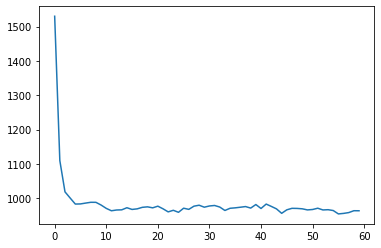

In [0]:
import matplotlib.pyplot as plt
plt.plot(losses)

##Generate word embeddings with mfcc feature

In [0]:
import pickle
with open("/content/drive/My Drive/Colab Notebooks/word_2_mfcc_first_50.pkl",'rb') as file:
  word_2_mfcc = pickle.load(file)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
print(word_2_mfcc.keys())
words = [w.lower() for w in word_2_mfcc.keys()]
mfccs = [padding(word_2_mfcc[w]) for w in word_2_mfcc.keys()]
x_dataset_ext = torch.tensor(mfccs,dtype=torch.float32)
ext_dataset = data.TensorDataset(x_dataset_ext)
print(x_dataset_ext.shape)
ext_loader = torch.utils.data.DataLoader(ext_dataset, batch_size=128, shuffle=False)

dict_keys(['CHAPTER', 'ONE', 'MISSUS', 'RACHEL', 'LYNDE', 'IS', 'SURPRISED', 'LIVED', 'JUST', 'WHERE', 'THE', 'AVONLEA', 'MAIN', 'ROAD', 'DIPPED', 'DOWN', 'INTO', 'A', 'LITTLE', 'HOLLOW', 'FRINGED', 'WITH', 'ALDERS', 'AND', 'LADIES', 'EARDROPS', 'TRAVERSED', 'BY', 'BROOK', 'THAT', 'HAD', 'ITS', 'SOURCE', 'AWAY', 'BACK', 'IN', 'WOODS', 'OF', 'OLD', 'CUTHBERT', 'PLACE', 'IT', 'WAS', 'REPUTED', 'TO', 'BE', 'AN', 'INTRICATE', 'HEADLONG', 'EARLIER', 'COURSE', 'THROUGH', 'THOSE', 'DARK', 'SECRETS', 'POOL', 'CASCADE', 'BUT', 'TIME', 'REACHED', "LYNDE'S", 'QUIET', 'WELL', 'CONDUCTED', 'STREAM', 'FOR', 'NOT', 'EVEN', 'COULD', 'RUN', 'PAST', 'DOOR', 'WITHOUT', 'DUE', 'REGARD', 'DECENCY', 'DECORUM', 'PROBABLY', 'CONSCIOUS', 'SITTING', 'AT', 'HER', 'WINDOW', 'KEEPING', 'SHARP', 'EYE', 'ON', 'EVERYTHING', 'PASSED', 'FROM', 'BROOKS', 'CHILDREN', 'UP', 'IF', 'SHE', 'NOTICED', 'ANYTHING', 'ODD', 'OR', 'OUT', 'WOULD', 'NEVER', 'REST', 'UNTIL', 'FERRETED', 'WHYS', 'WHEREFORES', 'THEREOF', 'THERE', 'ARE'

In [0]:
attn_new = Attention(decoder_hidden_dim, decoder_hidden_dim)
enc_new = Encoder(encoder_input_dim, encoder_hidden_dim)
dec_new = Decoder(decoder_output_dim,encoder_hidden_dim, decoder_hidden_dim, attn_new)
model_new = Seq2Seq(enc_new,dec_new,device).to(device)
model_new.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/speech2vec_model.pt'))
model_new.eval()

epoch_loss = 0
final_results = []
with torch.no_grad():
  epoch_loss = 0

  for i, batch in tqdm(enumerate(ext_loader)):
      
      src = batch[0].to(device)
      
      _,output = enc_new(src)

      output = torch.cat((output[0,:,:],output[1,:,:]),1)
      if i == 0:
        final_results = output.cpu().numpy()
      else:
        final_results = np.concatenate((final_results,output.cpu().numpy()))
      print(output.shape)
      print(final_results.shape)
      
      # # print(model.encoder.rnn.grad)
      # for name, parms in model.named_parameters():	
      #   print('-->name:', name, '-->grad_requirs:',parms.requires_grad, \
      #   ' -->grad_value:',parms.grad)


  
with open("/content/drive/My Drive/Colab Notebooks/speech_word2vec.txt", "w") as f:
    for offset,word in enumerate(words):
        f.write(word)
        f.write(" ")
        for i in range(0, 100):
            f.write(str(final_results[offset,i]))
            f.write(" ")
        f.write("\n")

torch.Size([128, 100])
(128, 100)
torch.Size([128, 100])
(256, 100)
torch.Size([128, 100])
(384, 100)
torch.Size([128, 100])
(512, 100)
torch.Size([128, 100])
(640, 100)
torch.Size([128, 100])
(768, 100)
torch.Size([128, 100])
(896, 100)
torch.Size([128, 100])
(1024, 100)
torch.Size([128, 100])
(1152, 100)
torch.Size([128, 100])
(1280, 100)
torch.Size([128, 100])
(1408, 100)
torch.Size([128, 100])
(1536, 100)
torch.Size([128, 100])
(1664, 100)
torch.Size([128, 100])
(1792, 100)
torch.Size([128, 100])
(1920, 100)
torch.Size([128, 100])
(2048, 100)
torch.Size([128, 100])
(2176, 100)
torch.Size([128, 100])
(2304, 100)
torch.Size([128, 100])
(2432, 100)
torch.Size([128, 100])
(2560, 100)
torch.Size([128, 100])
(2688, 100)
torch.Size([128, 100])
(2816, 100)
torch.Size([128, 100])
(2944, 100)
torch.Size([128, 100])
(3072, 100)
torch.Size([128, 100])
(3200, 100)
torch.Size([128, 100])
(3328, 100)
torch.Size([128, 100])
(3456, 100)
torch.Size([128, 100])
(3584, 100)
torch.Size([128, 100])
(371